In [44]:
# to install tensorflow and scikeras - you need to install these as they aren't preinstalled

import sys
# !{sys.executable} -m pip install -U tensorflow
# !{sys.executable} -m pip install -U scikeras

In [48]:
# standard quantitative packages
import numpy as np
import pandas as pd

# machine learning packages
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline

# visualisation
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

# tensorflow and keras for deep learning
import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasRegressor

# tensorflow - a implementation developed by Google that is particularly good at deep learning
# keras - an easy way of talking to tensorflow
# preferred over scikit-learn for deep learning, which is primarily used for machine learning

In [46]:
# lets run a regression multilayer perceptron on the California housing dataset
#   Note: this is a simplified version of the dataset with no missing data and no string/text data

from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()

housing

# note: target_names (what we want to predict) - MedHouseVal
# feature_names - our predictive variables

{'data': array([[   8.3252    ,   41.        ,    6.98412698, ...,    2.55555556,
           37.88      , -122.23      ],
        [   8.3014    ,   21.        ,    6.23813708, ...,    2.10984183,
           37.86      , -122.22      ],
        [   7.2574    ,   52.        ,    8.28813559, ...,    2.80225989,
           37.85      , -122.24      ],
        ...,
        [   1.7       ,   17.        ,    5.20554273, ...,    2.3256351 ,
           39.43      , -121.22      ],
        [   1.8672    ,   18.        ,    5.32951289, ...,    2.12320917,
           39.43      , -121.32      ],
        [   2.3886    ,   16.        ,    5.25471698, ...,    2.61698113,
           39.37      , -121.24      ]]),
 'target': array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894]),
 'frame': None,
 'target_names': ['MedHouseVal'],
 'feature_names': ['MedInc',
  'HouseAge',
  'AveRooms',
  'AveBedrms',
  'Population',
  'AveOccup',
  'Latitude',
  'Longitude'],
 'DESCR': '.. _california_housing_dataset:\n

In [49]:
# create training, testing, and validation datasets
#     Training dataset: used to fit the model
#     Validation dataset: used to fine-tune the model
#     Validation dataset is created by re-splitting the training set
#     Test dataset: 'blind data' used to check the accuracy of the model

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

In [50]:
# set up a basic deep learning model using sklearn to act as a baseline model
# using a Multilayer Regressor - similar to normal linear regression, except with hidden layers

# 1. Set up regression function
#    Note: best current practice is that hidden layers are all - a) large, and b) the same
mlp_reg = MLPRegressor(hidden_layer_sizes=[50, 50, 50], random_state=42)

# 2. Create pipeline that scales first, then regresses
pipeline = make_pipeline(StandardScaler(), mlp_reg)

# 3. Fit data to the pipeline
pipeline.fit(X_train, y_train)

# 4. Check fitted model against the fitted model using the validation dataset
y_pred = pipeline.predict(X_valid)

# 5. Calculate overall accuracy
rmse = mean_squared_error(y_valid, y_pred, squared=False)
rmse

0.5053326657968451

In [54]:
# set up a basic deep learning model using keras
#    Known as a 'sequential model'

# 1. specify a random seed so the model is replicable
tf.random.set_seed(42)

# 2. scale the data - Normalization is the same as StandardScaler in sklearn
norm_layer = keras.layers.Normalization(input_shape=X_train.shape[1:])

# 3. specify the basic model - one input and one output layer
model = keras.Sequential([
    norm_layer,
    keras.layers.Dense(50, activation='relu'),
    keras.layers.Dense(50, activation='relu'),
    keras.layers.Dense(50, activation='relu'),
    keras.layers.Dense(1)
])

# 4. set up a learning method for the model (this is the same as the method used by default in sklearn)
optimizer = keras.optimizers.Adam(learning_rate=1e-3)

# 5. combine steps together for full model specification
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])

# 6. fit the model (note - must first make sure that scaling (normalization) to applied to all data in the model)
#    'epochs' is how many times to optimise the model
norm_layer.adapt(X_train)
history = model.fit(X_train, y_train, epochs=20,
                   validation_data=(X_valid, y_valid))

# 7. see if the model prediction is 'good'
mse_test, rmse_test = model.evaluate(X_test, y_test)
rmse_test

# model is a bit worse than sklearn, we'll now set about improving that

Epoch 1/20
363/363 [==============================] - 2s 3ms/step - loss: 0.8536 - root_mean_squared_error: 0.9239 - val_loss: 0.4220 - val_root_mean_squared_error: 0.6496
Epoch 2/20
363/363 [==============================] - 1s 3ms/step - loss: 0.3840 - root_mean_squared_error: 0.6197 - val_loss: 0.7762 - val_root_mean_squared_error: 0.8810
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3611 - root_mean_squared_error: 0.6009 - val_loss: 0.4111 - val_root_mean_squared_error: 0.6412
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3469 - root_mean_squared_error: 0.5889 - val_loss: 0.6478 - val_root_mean_squared_error: 0.8048
Epoch 5/20
363/363 [==============================] - 1s 3ms/step - loss: 0.3325 - root_mean_squared_error: 0.5766 - val_loss: 0.5023 - val_root_mean_squared_error: 0.7087
Epoch 6/20
363/363 [==============================] - 1s 3ms/step - loss: 0.3220 - root_mean_squared_error: 0.5675 - val_loss: 0.3075 - val_

0.5398510694503784

In [55]:
# r_square for regression
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))


# re-running the sequential model with r_square added as a metric
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError", r_square])
history = model.fit(X_train, y_train, epochs=20,
                   validation_data=(X_valid, y_valid))

# testing the model on the test dataset
y_pred = model.predict(X_test)

Epoch 1/20
363/363 [==============================] - 2s 3ms/step - loss: 0.2672 - root_mean_squared_error: 0.5169 - r_square: 0.7868 - val_loss: 0.2881 - val_root_mean_squared_error: 0.5368 - val_r_square: 0.7592
Epoch 2/20
363/363 [==============================] - 1s 3ms/step - loss: 0.2681 - root_mean_squared_error: 0.5178 - r_square: 0.7860 - val_loss: 0.3385 - val_root_mean_squared_error: 0.5818 - val_r_square: 0.7030
Epoch 3/20
363/363 [==============================] - 1s 3ms/step - loss: 0.2657 - root_mean_squared_error: 0.5154 - r_square: 0.7891 - val_loss: 0.2774 - val_root_mean_squared_error: 0.5266 - val_r_square: 0.7681
Epoch 4/20
363/363 [==============================] - 1s 3ms/step - loss: 0.2645 - root_mean_squared_error: 0.5143 - r_square: 0.7859 - val_loss: 0.2636 - val_root_mean_squared_error: 0.5135 - val_r_square: 0.7832
Epoch 5/20
363/363 [==============================] - 1s 3ms/step - loss: 0.2621 - root_mean_squared_error: 0.5120 - r_square: 0.7899 - val_loss

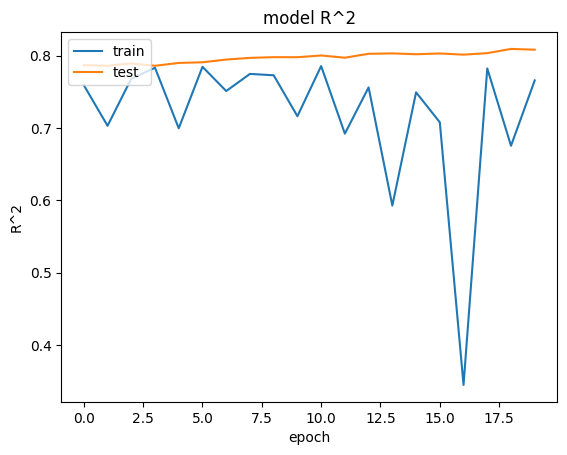

In [56]:
# plot training curve for R^2
#   Note: r_square is for training data, val_r_square is for test data
plt.plot(history.history['val_r_square'])
plt.plot(history.history['r_square'])
plt.title('model R^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

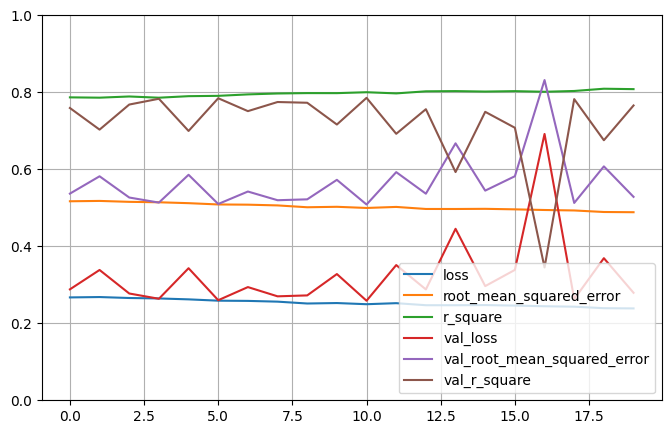

In [57]:
# alternative plot with all metrics
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 0.2342 - root_mean_squared_error: 0.4839 - r_square: 0.8122 - val_loss: 0.3384 - val_root_mean_squared_error: 0.5817 - val_r_square: 0.7038
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.2366 - root_mean_squared_error: 0.4865 - r_square: 0.8107 - val_loss: 0.2597 - val_root_mean_squared_error: 0.5096 - val_r_square: 0.7840
Epoch 3/20
363/363 [==============================] - 1s 3ms/step - loss: 0.2341 - root_mean_squared_error: 0.4839 - r_square: 0.8136 - val_loss: 0.2905 - val_root_mean_squared_error: 0.5390 - val_r_square: 0.7539
Epoch 4/20
363/363 [==============================] - 1s 3ms/step - loss: 0.2358 - root_mean_squared_error: 0.4856 - r_square: 0.8091 - val_loss: 0.2676 - val_root_mean_squared_error: 0.5173 - val_r_square: 0.7786
Epoch 5/20
363/363 [==============================] - 1s 3ms/step - loss: 0.2355 - root_mean_squared_error: 0.4853 - r_square: 0.8105 - val_loss

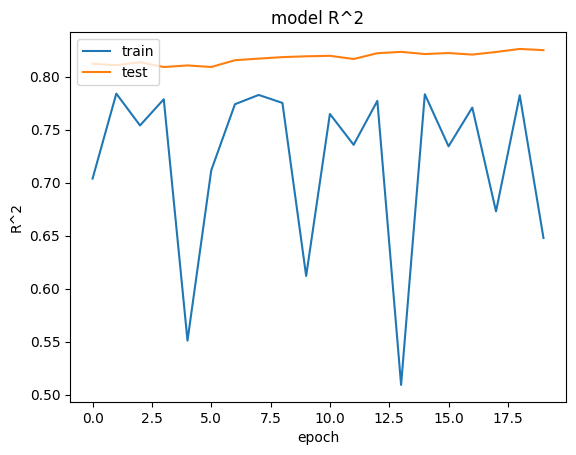

In [58]:
# we'll now build a more complex model using the Functional API
#    This allows greater flexibility over a standard Sequential model

# 1. first set up the scaling
normalization_layer = keras.layers.Normalization()

# 2. now two hidden layers (you can set up as many as you want)
hidden_layer1 = keras.layers.Dense(30, activation='relu')
hidden_layer2 = keras.layers.Dense(30, activation='relu')

# 3. now a concat layer - essentially this creates a feedback loop within your testing
concat_layer = keras.layers.Concatenate()

# 4. now an output layer with a single prediction
output_layer = keras.layers.Dense(1)

# 5. now bring it all together - key is to link each layer to the previous layer
input_ = keras.layers.Input(shape=X_train.shape[1:])
normalized = normalization_layer(input_)
hidden1 = hidden_layer1(normalized)
hidden2 = hidden_layer2(hidden1)
concat = concat_layer([normalized, hidden2])
output = output_layer(concat)

# 6. specify the full model
model2 = keras.Model(inputs=[input_], outputs=[output])

# 7. fit the model
model2.compile(loss='mse', metrics=["RootMeanSquaredError", r_square], 
               optimizer=optimizer)
history2 = model.fit(X_train, y_train, epochs=20,
                   validation_data=(X_valid, y_valid))

# 8. predict from the model
y_pred = model2.predict(X_test)

# 9. see if the model prediction is 'good'
rmse_test2 = model2.evaluate(X_test, y_test)
print(rmse_test2)

# 10. plot the accuracy
plt.plot(history2.history['val_r_square'])
plt.plot(history2.history['r_square'])
plt.title('model R^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# note: accuracy is notably better

In [63]:
# what if we wanted some features to be direct predictors and some features to go through
#    hidden layers? This might be useful when we have a spread of known strong predictors
#    and some weaker indirect predictors

# We are going to send features 0 to 4 through direct prediction, and features 2 to 7
#   (so we are using some of the features twice) through hidden layers


# 1. we start by specifying all the relevant layers
input_wide = keras.layers.Input(shape=[5]) # features 0 to 4
input_deep = keras.layers.Input(shape=[6]) # features 2 to 7
norm_layer_wide = keras.layers.Normalization()
norm_layer_deep = keras.layers.Normalization()
norm_wide = norm_layer_wide(input_wide)
norm_deep = norm_layer_deep(input_deep)
hidden1 = keras.layers.Dense(30, activation='relu')(norm_deep)
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)
concat = keras.layers.concatenate([norm_wide, hidden2])
output = keras.layers.Dense(1)(concat)
model = keras.Model(inputs=[input_wide, input_deep], outputs=[output])

# 2. specify the model, similar to previous
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
X_train_wide, X_train_deep = X_train[:, :5], X_train[:, 2:]
X_valid_wide, X_valid_deep = X_valid[:, :5], X_valid[:, 2:]
X_test_wide, X_test_deep = X_test[:, :5], X_test[:, 2:]

# 3. fit the model
norm_layer_wide.adapt(X_train_wide)
norm_layer_deep.adapt(X_train_deep)
history = model.fit((X_train_wide, X_train_deep), y_train, epochs=20,
                     validation_data=((X_valid_wide, X_valid_deep), y_valid))

# 4. evaluate the model
rmse_test = model.evaluate((X_test_wide, X_test_deep), y_test)
print(rmse_test)



Epoch 1/20
363/363 [==============================] - 2s 3ms/step - loss: 1.5607 - root_mean_squared_error: 1.2493 - val_loss: 0.8045 - val_root_mean_squared_error: 0.8970
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5026 - root_mean_squared_error: 0.7090 - val_loss: 1.0182 - val_root_mean_squared_error: 1.0091
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4520 - root_mean_squared_error: 0.6723 - val_loss: 0.4113 - val_root_mean_squared_error: 0.6413
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4190 - root_mean_squared_error: 0.6473 - val_loss: 0.7263 - val_root_mean_squared_error: 0.8522
Epoch 5/20
363/363 [==============================] - 1s 3ms/step - loss: 0.4056 - root_mean_squared_error: 0.6369 - val_loss: 0.4669 - val_root_mean_squared_error: 0.6833
Epoch 6/20
363/363 [==============================] - 1s 3ms/step - loss: 0.3858 - root_mean_squared_error: 0.6211 - val_loss: 0.7631 - val_

In [64]:
# fine-tuning our model

# we first install a package that can enable fine-tuning

!python -m pip install keras_tuner

                                              0.0/176.1 kB ? eta -:--:--
     -------------------------------------- 176.1/176.1 kB 5.4 MB/s eta 0:00:00


In [71]:
# fine-tuning our hyperparameters

import keras_tuner as kt

def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=0, max_value=8, default=2)
    n_neurons = hp.Int("n_neurons", min_value=16, max_value=256, step=16, default=64)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log", default=1e-3)
    optimizer_choice = hp.Choice("optimizer", values=["sgd", "adam"])
    
    # set up the normalization layer
    normalization_layer = keras.layers.Normalization()

    # adapt the normalization layer to the data
    normalization_layer.adapt(X_train)

    # Input layer
    input_ = keras.layers.Input(shape=X_train.shape[1:])
    normalized = normalization_layer(input_)

    # Hidden layers
    for layer in range(n_hidden):
        if layer == 0:
            x = keras.layers.Dense(n_neurons, activation="relu")(normalized)
        else:
            x = keras.layers.Dense(n_neurons, activation="relu")(x)
    
    # Concatenation layer
    concat = keras.layers.Concatenate()([normalized, x])

    # Output layer
    output = keras.layers.Dense(1)(concat)

    model = keras.Model(inputs=[input_], outputs=[output])

    # Choose the optimizer based on the hyperparameter
    if optimizer_choice == "sgd":
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
    return model

tuner = kt.RandomSearch(
    build_model,
    objective=kt.Objective("val_root_mean_squared_error", direction="min"), 
    max_trials=5,
    overwrite=True,
    directory='my_dir',
    project_name='cali_house'
)

tuner.search(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

top_models = tuner.get_best_models(num_models=3)
best_model = top_models[0]




Trial 30 Complete [00h 00m 41s]
val_root_mean_squared_error: 0.7899082899093628

Best val_root_mean_squared_error So Far: 0.512519121170044
Total elapsed time: 00h 12m 30s
INFO:tensorflow:Oracle triggered exit


In [75]:
# lets check the model
#   note, the rmse here is for the test dataset, not the validation dataset

loss, rmse = best_model.evaluate(X_test, y_test)
print("Test set loss: ", loss)
print("Test set RMSE: ", rmse)

121/121 [==============================] - 0s 2ms/step - loss: 0.2627 - root_mean_squared_error: 0.5125
Test set loss:  0.26267582178115845
Test set RMSE:  0.512519121170044


In [ ]:
# to save and reload the model

# save
best_model.save('best_model.h5')

# reload
from keras.models import load_model
model = load_model('best_model.h5')

In [94]:
# LSTM deep learning models for stock price prediction
#    Long Short Term Model - a type of Recurrent Neural Network

tesla = pd.read_csv('TSLA.csv')
tesla.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-07-02,244.296005,245.600006,237.119995,241.731995,241.731995,86250500
1,2020-07-06,255.337997,275.558014,253.207993,274.316010,274.316010,102849500
2,2020-07-07,281.002014,285.899994,267.342010,277.971985,277.971985,107448500
3,2020-07-08,281.000000,283.451996,262.268005,273.175995,273.175995,81556500
4,2020-07-09,279.398010,281.712006,270.256012,278.855988,278.855988,58588000


In [95]:
tesla.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504 entries, 0 to 503
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       504 non-null    object 
 1   Open       504 non-null    float64
 2   High       504 non-null    float64
 3   Low        504 non-null    float64
 4   Close      504 non-null    float64
 5   Adj Close  504 non-null    float64
 6   Volume     504 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 27.7+ KB


In [96]:
# reduce the dataset down to just the necessary data

tesla = tesla[['Date','Open','Close']] 
tesla['Date'] = pd.to_datetime(tesla['Date']) 
tesla.set_index('Date',drop=True,inplace=True) 
tesla.head()

,Open,Close
Date,,
2020-07-02,244.296005,241.731995
2020-07-06,255.337997,274.316010
2020-07-07,281.002014,277.971985
2020-07-08,281.000000,273.175995
2020-07-09,279.398010,278.855988


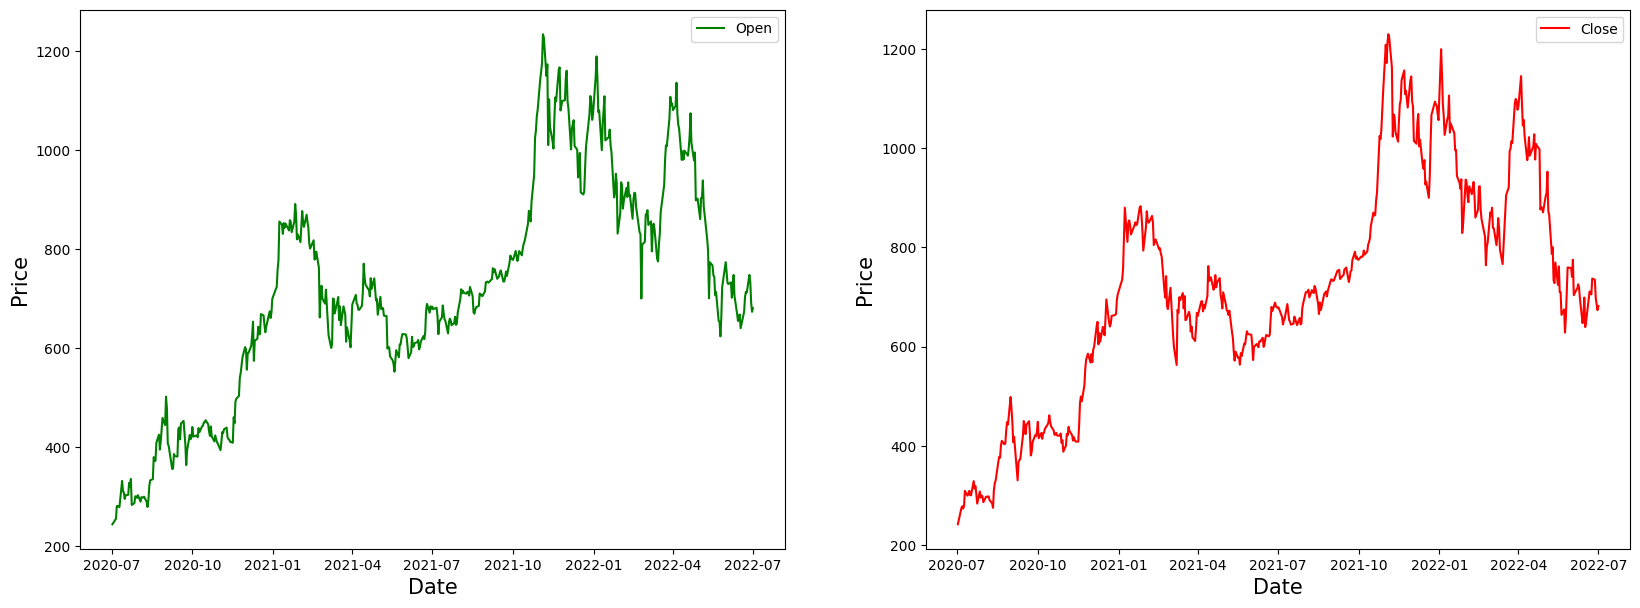

In [97]:
# chart the open and close stock prices

fig, ax =plt.subplots(1,2,figsize=(20,7))
ax[0].plot(tesla['Open'],label='Open',color='green')
ax[0].set_xlabel('Date',size=15)
ax[0].set_ylabel('Price',size=15)
ax[0].legend()
ax[1].plot(tesla['Close'],label='Close',color='red')
ax[1].set_xlabel('Date',size=15)
ax[1].set_ylabel('Price',size=15)
ax[1].legend()
plt.show()


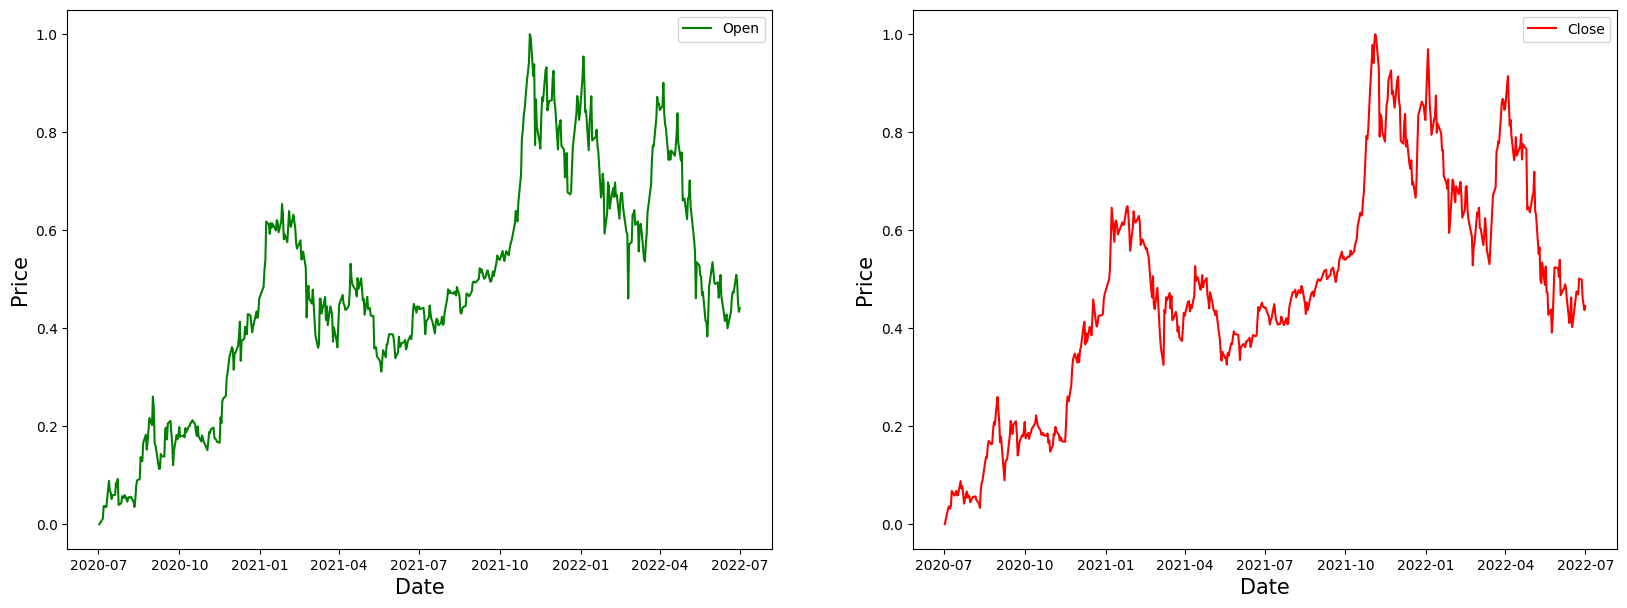

In [98]:
from sklearn.preprocessing import MinMaxScaler
MinMax = MinMaxScaler()
tesla[tesla.columns] = MinMax.fit_transform(tesla)

fig, ax =plt.subplots(1,2,figsize=(20,7))
ax[0].plot(tesla['Open'],label='Open',color='green')
ax[0].set_xlabel('Date',size=15)
ax[0].set_ylabel('Price',size=15)
ax[0].legend()
ax[1].plot(tesla['Close'],label='Close',color='red')
ax[1].set_xlabel('Date',size=15)
ax[1].set_ylabel('Price',size=15)
ax[1].legend()
plt.show()

In [99]:
# create a training and test dataset that trains on the first (chronologically) 80% of datapoints
training_size = round(len(tesla) * 0.80)
train_data = tesla[:training_size]
test_data  = tesla[training_size:]

def create_sequence(dataset):
  sequences = []
  labels = []

  start_idx = 0

  for stop_idx in range(50,len(dataset)): 
    sequences.append(dataset.iloc[start_idx:stop_idx])
    labels.append(dataset.iloc[stop_idx])
    start_idx += 1
  return (np.array(sequences),np.array(labels))

train_seq, train_label = create_sequence(train_data)
test_seq, test_label = create_sequence(test_data)


In [100]:
# run the LSTM model

model5 = keras.models.Sequential()
model5.add(keras.layers.LSTM(units=50, return_sequences=True, 
               input_shape = (train_seq.shape[1], train_seq.shape[2])))

model5.add(keras.layers.Dropout(0.1)) 
model5.add(keras.layers.LSTM(units=50))

model5.add(keras.layers.Dense(2))

model5.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

model5.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50, 50)            10600     
                                                                 
 dropout_1 (Dropout)         (None, 50, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dense_5 (Dense)             (None, 2)                 102       
                                                                 
Total params: 30,902
Trainable params: 30,902
Non-trainable params: 0
_________________________________________________________________


In [101]:
model5.fit(train_seq, train_label, epochs=40,validation_data=(test_seq, test_label), verbose=1)
test_predicted = model5.predict(test_seq)
test_inverse_predicted = MinMax.inverse_transform(test_predicted)

Epoch 1/40
12/12 [==============================] - 6s 121ms/step - loss: 0.0771 - mean_absolute_error: 0.2188 - val_loss: 0.0210 - val_mean_absolute_error: 0.1302
Epoch 2/40
12/12 [==============================] - 1s 43ms/step - loss: 0.0104 - mean_absolute_error: 0.0740 - val_loss: 0.0058 - val_mean_absolute_error: 0.0602
Epoch 3/40
12/12 [==============================] - 1s 45ms/step - loss: 0.0064 - mean_absolute_error: 0.0631 - val_loss: 0.0059 - val_mean_absolute_error: 0.0609
Epoch 4/40
12/12 [==============================] - 1s 44ms/step - loss: 0.0054 - mean_absolute_error: 0.0521 - val_loss: 0.0095 - val_mean_absolute_error: 0.0795
Epoch 5/40
12/12 [==============================] - 1s 45ms/step - loss: 0.0055 - mean_absolute_error: 0.0551 - val_loss: 0.0050 - val_mean_absolute_error: 0.0555
Epoch 6/40
12/12 [==============================] - 1s 49ms/step - loss: 0.0046 - mean_absolute_error: 0.0487 - val_loss: 0.0078 - val_mean_absolute_error: 0.0701
Epoch 7/40
12/12 [===

In [102]:
len(test_seq)

51

In [103]:
# Merging actual and predicted data for better visualization
tesla_predict = pd.concat([tesla.iloc[-51:].copy(),pd.DataFrame
                           (test_inverse_predicted,columns=['open_predicted','close_predicted']
                            ,index=tesla.iloc[-51:].index)], axis=1)

tesla_predict[['Open','Close']] = MinMax.inverse_transform(tesla_predict[['Open','Close']])

tesla_predict.head()

,Open,Close,open_predicted,close_predicted
Date,,,,
2022-04-20,1030.000000,977.200012,941.308411,976.956604
2022-04-21,1074.729980,1008.780029,938.443359,975.734314
2022-04-22,1014.909973,1005.049988,941.330627,980.737610
2022-04-25,978.969971,998.020020,944.290466,984.389771
2022-04-26,995.429993,876.419983,945.439270,985.018127


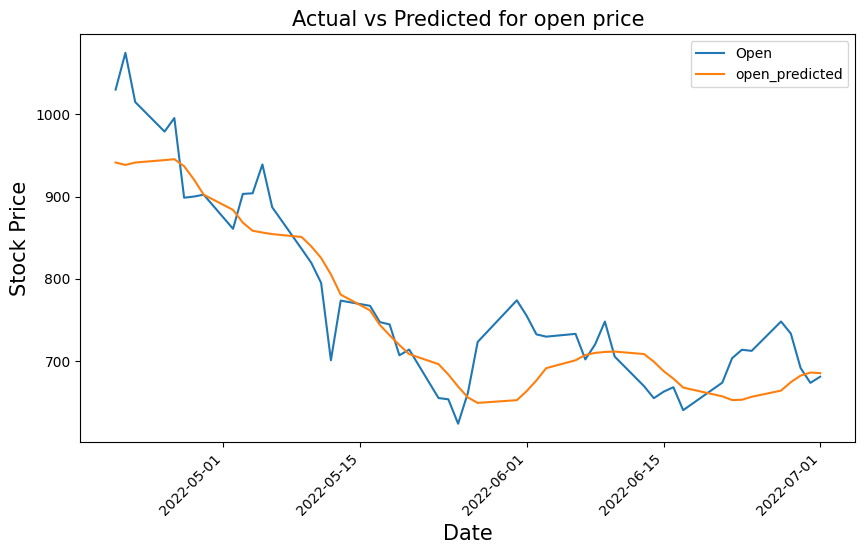

In [104]:
# chart showing prediction

tesla_predict[['Open','open_predicted']].plot(figsize=(10,6))
plt.xticks(rotation=45)
plt.xlabel('Date',size=15)
plt.ylabel('Stock Price',size=15)
plt.title('Actual vs Predicted for open price',size=15)
plt.show()

In [105]:
tesla_predict.tail()

,Open,Close,open_predicted,close_predicted
Date,,,,
2022-06-27,748.099976,734.760010,664.102905,692.831665
2022-06-28,733.450012,697.989990,674.336548,704.452332
2022-06-29,691.500000,685.469971,682.318237,712.262817
2022-06-30,673.530029,673.419983,686.042969,714.393127
2022-07-01,681.000000,681.789978,685.351685,711.527710


In [106]:
# Predict the next ten days stock prices
#   1. Create extra rows for those next ten days

extra_rows = pd.DataFrame(columns=tesla_predict.columns, 
                          index=pd.date_range(start=tesla_predict.index[-1], periods=11, freq='D', inclusive='right'))
tesla_predict = pd.concat([tesla_predict, extra_rows])

tesla_predict.tail(15)

,Open,Close,open_predicted,close_predicted
2022-06-27,748.099976,734.760010,664.102905,692.831665
2022-06-28,733.450012,697.989990,674.336548,704.452332
2022-06-29,691.500000,685.469971,682.318237,712.262817
2022-06-30,673.530029,673.419983,686.042969,714.393127
2022-07-01,681.000000,681.789978,685.351685,711.527710
2022-07-02,NaN,NaN,NaN,NaN
2022-07-03,NaN,NaN,NaN,NaN
2022-07-04,NaN,NaN,NaN,NaN
2022-07-05,NaN,NaN,NaN,NaN
2022-07-06,NaN,NaN,NaN,NaN


1/1 [==============================] - 0s 35ms/step


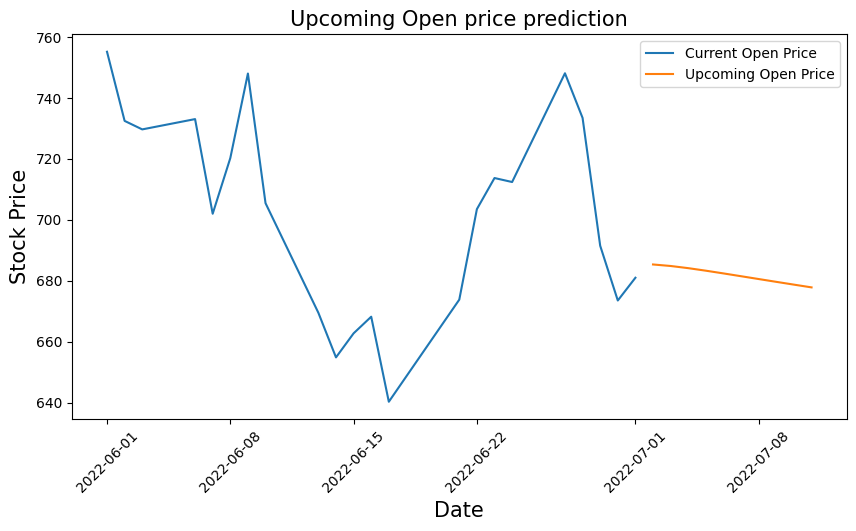

In [107]:
# Predict the next ten days stock prices
#   2. Run the prediction model

upcoming_prediction = pd.DataFrame(columns=['Open','Close'],index=tesla_predict.index)
upcoming_prediction.index=pd.to_datetime(upcoming_prediction.index)

curr_seq = test_seq[-1:]

for i in range(-10,0):
  up_pred = model5.predict(curr_seq)
  upcoming_prediction.iloc[i] = up_pred
  curr_seq = np.append(curr_seq[0][1:],up_pred,axis=0)
  curr_seq = curr_seq.reshape(test_seq[-1:].shape)
    
upcoming_prediction[['Open','Close']] = MinMax.inverse_transform(
    upcoming_prediction[['Open','Close']])

fig,ax=plt.subplots(figsize=(10,5))
ax.plot(tesla_predict.loc['2022-06-01':,'Open'],label='Current Open Price')
ax.plot(upcoming_prediction.loc['2022-06-01':,'Open'],label='Upcoming Open Price')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
ax.set_xlabel('Date',size=15)
ax.set_ylabel('Stock Price',size=15)
ax.set_title('Upcoming Open price prediction',size=15)
ax.legend()
plt.show()